In [2]:
import torch
from torch.autograd import Variable
import time
import numpy as np
from maddpg.utils.buffer import ReplayBuffer
from maddpg.algorithms.maddpg import MADDPG

from pettingzoo.sisl import multiwalker_v7

from copy import deepcopy
from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams.update({'axes.labelsize':16, 'xtick.labelsize':13, 'ytick.labelsize':13, 'legend.fontsize':14, 'legend.title_fontsize':14, 
                     'figure.titlesize':16, 'axes.titlesize': 14, "font.size":14, 'figure.figsize': (20,5), 'lines.linewidth': 1, 
                     'lines.linestyle': '-'})

In [3]:
def plot(frame_idx, scores, save_pic=False):
    clear_output(True)
    plt.figure(figsize=(24, 5))
   
    mean_score = 0
    colors = ['b', 'm', 'c', 'g', 'y']
    for i, sc in enumerate(scores):
        mean_score += np.mean(scores[sc][-20:])
        plt.plot(scores[sc], colors[i], linewidth=1, label=sc)   
    plt.title(f"frame {frame_idx}. score: {mean_score:.2f}")
    plt.axhline(y=0.0, color='grey', linestyle='--')
    plt.legend()
    if save_pic:
        plt.savefig(f'results_eps-{frame_idx}_{(time.asctime()[4:16].replace(":","-"))}.png')
    plt.show()
    
def dic_builder(num_walkers, value):
    return {f'walker_{n}':deepcopy(value) for n in range(num_walkers)}

In [4]:
env = multiwalker_v7.env()
print('Observation space:', env.observation_spaces['walker_0'].shape)
print('Action space:', env.action_spaces['walker_0'].shape)

Observation space: (31,)
Action space: (4,)


In [12]:
USE_CUDA = True
MODEL_DIR = 'models/'
LOG_DIR = 'logs/'
AGENT_ALG = "MADDPG"
ADVERSARY_ALG = "DDPG"
TAU = 0.01
LR = 0.005
HIDDEN_DIM = 300
BUFFER_LENGTH = int(1e6)
BATCH_SIZE = 1024
OBS_DIM = env.observation_spaces['walker_0'].shape[0]
ACT_DIM = env.action_spaces['walker_0'].shape[0]

Init_noise_scale = 0.3
Final_noise_scale = 0.0
SAVE_INTERVAL = 500
Plot_interval = 5

EPISODE_LEN = 500
Steps_per_update = 10
N_rollout_threads = 1
N_training_threads = 1  # how much times to train in 1 step
N_EPISODES = 20000
N_exploration_eps = 10000
N_AGENTS = 2

In [6]:
env = multiwalker_v7.env(n_walkers=N_AGENTS, max_cycles=EPISODE_LEN) #, forward_reward=1.0)

In [13]:
agent_params = {'num_in_pol': OBS_DIM, 'num_out_pol': ACT_DIM, 
                'num_in_critic': (OBS_DIM+ACT_DIM) * N_AGENTS if AGENT_ALG == 'MADDPG' else 1}

maddpg = MADDPG(agent_init_params=[deepcopy(agent_params) for _ in range(N_AGENTS)],
                alg_types=[deepcopy(AGENT_ALG) for _ in range(N_AGENTS)],
                tau=TAU, lr=LR, hidden_dim=HIDDEN_DIM)

In [8]:
replay_buffer = ReplayBuffer(BUFFER_LENGTH, N_AGENTS, [deepcopy(OBS_DIM) for _ in range(N_AGENTS)], [deepcopy(ACT_DIM) for _ in range(N_AGENTS)])
logger = None

# Training

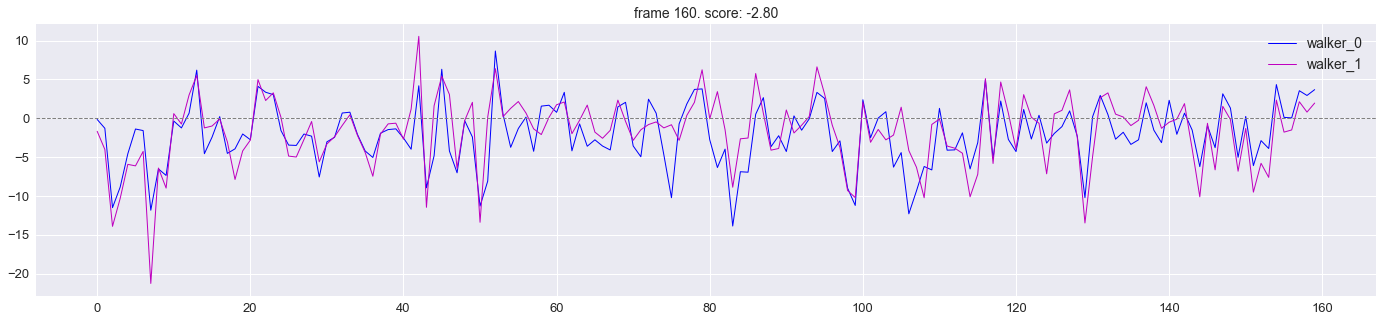

Episode 162 Reward: 0.02  Average Score: -0.01 best: 0.03  model updates: 5021           

In [ ]:
avg_score = 0
best_score = 0
scores = dic_builder(2, [])
t0 = time.time()
for ep_i in range(0, N_EPISODES):
    env.reset()
    states = np.zeros((1, N_AGENTS, OBS_DIM))
    actions = np.zeros((N_AGENTS, ACT_DIM))
    rewards = np.zeros((1, N_AGENTS))
    next_states = np.zeros((1, N_AGENTS, OBS_DIM))
    dones = np.zeros((1, N_AGENTS))
    round_score = np.zeros((N_AGENTS, 1))
    
    # obs.shape = (n_rollout_threads, nagent)(nobs), nobs differs per agent so not tensor
    maddpg.prep_rollouts(device='cpu')

    explr_pct_remaining = max(0, N_exploration_eps - ep_i) / N_exploration_eps
    maddpg.scale_noise(Final_noise_scale + (Init_noise_scale - Final_noise_scale) * explr_pct_remaining)
    maddpg.reset_noise()

    for t, wlkr in enumerate(env.agent_iter()):
        i_a = t % N_AGENTS
        next_states[:, i_a], rewards[:, i_a], dones[:, i_a], _ = env.last()
        
        if dones[0, i_a]:
            if dones.all():
                break
            env.step(None)
            continue
        
        if i_a == N_AGENTS - 1: # saving info once in cycle of agents moves
            replay_buffer.push(states, actions, rewards, next_states, dones)
        states[:, i_a] = deepcopy(next_states[:, i_a])
        
        torch_obs = Variable(torch.Tensor(next_states[:, i_a]), requires_grad=False)
        # get actions as torch Variables
        torch_agent_actions = maddpg.step(torch_obs, i_a, explore=True)
        # convert actions to numpy arrays
        actions[i_a] = deepcopy(torch_agent_actions.data.numpy())
        env.step(actions[i_a])
        round_score[i_a] += sum(rewards[:, i_a])
    
        # training
        if (len(replay_buffer) >= BATCH_SIZE and
            ((t+1) % Steps_per_update) == 0):
            if USE_CUDA:
                maddpg.prep_training(device='gpu')
            else:
                maddpg.prep_training(device='cpu')
            for u_i in range(N_training_threads):
                for a_i in range(N_AGENTS):
                    sample = replay_buffer.sample(BATCH_SIZE, to_gpu=USE_CUDA)
                    maddpg.update(sample, a_i, logger=logger)
                maddpg.update_all_targets()
            maddpg.prep_rollouts(device='cpu')
            
    ep_rews = replay_buffer.get_average_rewards(EPISODE_LEN)
    for i, sc in enumerate(scores):
        scores[sc].append(round_score[i])
    avg_score = np.mean(ep_rews) * 0.05 + avg_score * 0.95 
    if best_score < np.mean(ep_rews):
        best_score = np.mean(ep_rews)
    
    if ep_i % Plot_interval == Plot_interval - 1:
        plot(ep_i+1, scores)
#     for a_i, a_ep_rew in enumerate(ep_rews):
#         logger.add_scalar('agent%i/mean_episode_rewards' % a_i, a_ep_rew, ep_i)
    print('\rEpisode {} Reward: {:.2f}  Average Score: {:.2f} best: {:.2f}  model updates: {}'.format(ep_i+1, np.mean(ep_rews), 
                                                                                avg_score, best_score, maddpg.niter), ' '*10, end="")
        
    if ep_i % SAVE_INTERVAL == SAVE_INTERVAL - 1:
        maddpg.save(MODEL_DIR + f'model_ddpg_ep{ep_i+1}.pt')
        maddpg.save(MODEL_DIR + 'model_ddpg.pt')

maddpg.save(MODEL_DIR + 'model_ddpg.pt')
env.close()
plot(ep_i+1, scores, save_pic=True)
print("training took {} min!".format((time.time()-t0)/60))

In [16]:
maddpg2 = MADDPG.init_from_save(MODEL_DIR + 'model_ep29000.pt')

In [31]:
for i in range(2):
    maddpg.agents[i].policy = deepcopy(maddpg2.agents[i].policy)
#     maddpg.agents[i].critic = deepcopy(maddpg2.agents[i].policy)
#     maddpg.agents[i].policy_optimizer = deepcopy(maddpg2.agents[i].policy)
#     maddpg.agents[i].policy = deepcopy(maddpg2.agents[i].policy)

In [32]:
maddpg.agents[i].critic.fc1

Linear(in_features=70, out_features=300, bias=True)

In [41]:
play(500, True, 'ep_29000')

score = -5.77


In [71]:
def play(max_t=1000, graphics=False, video_to_file=False):
    env = multiwalker_v7.env(n_walkers=N_AGENTS, max_cycles=max_t, forward_reward=1.0)
    if video_to_file:
        import cv2
        frame_list = []

    maddpg.prep_rollouts(device='cpu')
    
    with torch.no_grad():
        for i_episode in range(1):
            
            env.reset()
            state = dic_builder(N_AGENTS, np.zeros((1, 31)))
            action = dic_builder(N_AGENTS, np.zeros((4)))
            reward = dic_builder(N_AGENTS, 0)
            next_state = dic_builder(N_AGENTS, np.zeros((1, 31)))
            done = dic_builder(N_AGENTS, False)
            score = 0
            
            for t, wlkr in enumerate(env.agent_iter()):
                i_a = t % N_AGENTS
                state[wlkr], reward[wlkr], done[wlkr], _ = env.last()
                if graphics:
                    if video_to_file:
                        frame = env.render(mode='rgb_array')
                        frame_list.append(deepcopy(frame))
                    else:
                        env.render()
                if done[wlkr]:
                    if all(done):
                        env.close()
                        break
                    env.step(None)
                    continue

                state[wlkr] = state[wlkr].reshape((1, OBS_DIM))
                torch_obs = Variable(torch.Tensor(state[wlkr]), requires_grad=False)
                # get actions as torch Variables
                torch_agent_actions = maddpg.step(torch_obs, i_a, explore=False)
                # convert actions to numpy arrays
                action[wlkr] = deepcopy(torch_agent_actions.data.numpy())
                env.step(action[wlkr][0])

                score += reward[wlkr] / N_AGENTS
            
            print(f'{score = :.2f}')
            env.reset()

        env.close()
    if video_to_file:
#         fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        fourcc = cv2.VideoWriter_fourcc(*'X264') # works with jupyter but bigger
#         fourcc = cv2.VideoWriter_fourcc(*'DIVX')
#         fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(video_to_file+'.mp4', fourcc, 50, (frame_list[0].shape[1] ,frame_list[0].shape[0]))
 
        for images in frame_list:
            out.write(cv2.cvtColor(np.array(images),cv2.COLOR_BGR2RGB))
        out.release()

In [72]:
play(500, True, 'ep_20000')

score = 2.07


In [1]:
from torchinfo import summary 

In [22]:
col_names=[     "input_size",
                "output_size",
                "num_params",
#                 "kernel_size",
#                 "mult_adds",
          ]

In [29]:
_= summary(maddpg.agents[0].policy, input_size=(1,31), col_names=col_names, verbose=1)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MLPNetwork                               --                        --                        --
├─BatchNorm1d: 1-1                       [1, 31]                   [1, 31]                   62
├─Linear: 1-2                            [1, 31]                   [1, 300]                  9,600
├─Linear: 1-3                            [1, 300]                  [1, 300]                  90,300
├─Linear: 1-4                            [1, 300]                  [1, 4]                    1,204
Total params: 101,166
Trainable params: 101,166
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.40
Estimated Total Size (MB): 0.41
